# Flight Price Prediction

Statistical learning project

a.y. 2022/2023

**group 13/15:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import random                                    
from math import isnan
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
import re
import os



**Data Cleaning**

In [29]:

cartella = r'C:\Users\loren\Downloads\progettoSL\scraping'

elenco_file = [file for file in os.listdir(cartella) if file.endswith('.xlsx')]

if not elenco_file:
    print("Nessun file Excel trovato nella cartella.")
else:
    primo_file = os.path.join(cartella, elenco_file[0])
    df_completo = pd.read_excel(primo_file)

    col_name_mapping = {
        'data-ril': 'data_ril',
        'dara_ril': 'data_ril',
        'dati_ril': 'data_ril',
        'aeroproto_partenza': 'aeroporto_partenza',
        'oario_partenza':'orario_partenza',
        'oario_arrivo':'orario_arrivo',
        'orario_arrivp':'orario_arrivo',
        'orario_partenzal':'orario_partenza',
        'orariopartenza':'orario_partenza',
        'orario_partenza ':'orario_partenza',
        'Tariffa': 'tariffa',
        'tariffa ': 'tariffa',
        'tariffa  ': 'tariffa',
        'tariffa   ': 'tariffa',
        'operatore ':'operatore',
        'data_partenza ':'data_partenza',
        'data_ril ':'data_ril'
    }

    for col_old, col_new in col_name_mapping.items():
        if col_old in df_completo.columns:
            df_completo.rename(columns={col_old: col_new}, inplace=True)

    for file in elenco_file[1:]:
        percorso_file = os.path.join(cartella, file)
        df = pd.read_excel(percorso_file)

        for col_old, col_new in col_name_mapping.items():
            if col_old in df.columns:
                df.rename(columns={col_old: col_new}, inplace=True)

        df_completo = pd.concat([df_completo, df], ignore_index=True)

    percorso_output = r'C:\Users\loren\Downloads\progettoSL\dataset.xlsx'

    df_completo.to_excel(percorso_output, index=False)



In [2]:
data = pd.read_excel('dataset.xlsx')

In [3]:
data

,orario_partenza,orario_arrivo,aeroporto_partenza,aeroporto_arrivo,tipo,durata,operatore,prezzo,tariffa,data_partenza,data_ril,distanza
0,6:15,9:25,FCO,JTR,diretto,2h 10m,Vueling,127 €,Economy,lun 24/7,21\6',1273
1,6:15,9:25,FCO,JTR,diretto,2h 10m,Vueling,127 €,Economy,lun 24/7,21\6',1273
2,7:05,23:59,FCO,JTR,1 scalo,15h 54m,Ryanair,76 €,Tariffa Standard,lun 24/7,21\6',1273
3,6:15,9:25,FCO,JTR,diretto,2h 10m,Iberia,268 €,Tariffa di base,lun 24/7,21\6',1273
4,17:05,23:30,FCO,JTR,1 scalo,5h 25m,"Aeroitalia, Volotea",102 €,Economy,lun 24/7,21\6',1273
...,...,...,...,...,...,...,...,...,...,...,...,...
86488,17:35,1:20+1,FCO,KEF,1 scalo,9h 45m,"Vueling, PLAY",442 €,Economy,dom 20/8,18\7',3322
86489,11:25,0:10+1,FCO,KEF,1 scalo,14h 45m,Scandinavian Airlines,437 €,Economy,dom 20/8,18\7',3322
86490,20:50,9:45+1,FCO,KEF,1 scalo,14h 55m,Scandinavian Airlines,437 €,Economy,dom 20/8,18\7',3322
86491,13:25,23:30,FCO,KEF,1 scalo,12h 05m,Lufthansa,498 €,Economy Light,dom 20/8,18\7',3322


Features Engineering

In [4]:
#data = pd.read_excel('dataset.xlsx')
data.dropna(inplace = True)

data = data[~data.index.duplicated(keep='first')]

data = data[~data['orario_arrivo'].str.contains('\+1')]
data = data[~data['operatore'].str.contains('Flixbus')]
data = data[~data['operatore'].str.contains('FlixBus')]
data = data[~data['aeroporto_partenza'].str.contains('DBV')]
data = data[~data['operatore'].str.contains('Treno')]
data = data[~data['operatore'].str.contains('Italotreno')]
data = data[~data['operatore'].str.contains('Trenitalia')]
data = data[~data['tipo'].str.contains('2 scali')]
#data = data[~data['operatore'].str.contains('Aeroitalia')]

In [5]:
def clean_price(value):
    if isinstance(value, (int, float)):
        return value
    try:
        new_price = int(re.sub(r'[^\d]', '', str(value)))
        return new_price
    except:
        return None

data['prezzo'] = data['prezzo'].apply(clean_price)
#data.dropna(subset=['prezzo'], inplace=True)


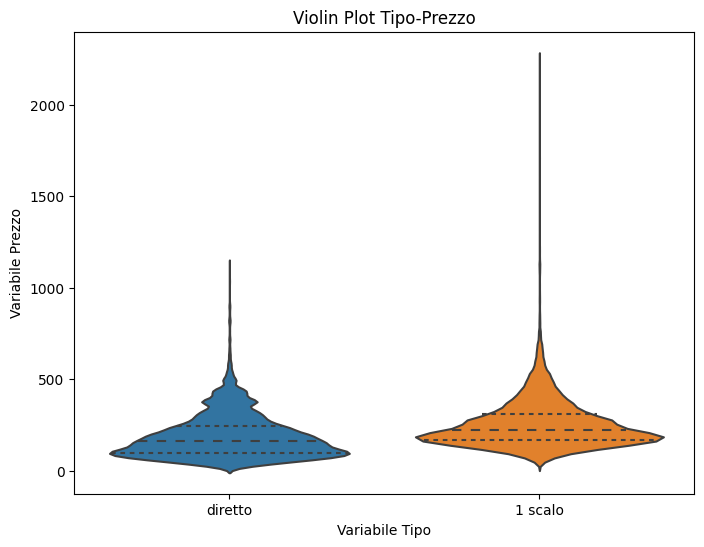

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

#violin plot Tipo-Prezzo
plt.figure(figsize=(8, 6))
sns.violinplot(x='tipo', y='prezzo', data=data, inner='quartile') #X deve corrispondere a una variabili binaria, quindi escludere durata
plt.title('Violin Plot Tipo-Prezzo')
plt.xlabel('Variabile Tipo')
plt.ylabel('Variabile Prezzo')
plt.show()

In [7]:
def transform_row(row):
    if row['tipo'] == 'diretto':
        row['tipo'] = 0
    elif row['tipo'] == '1 scalo' or row['tipo'] == '1 cambio':
        row['tipo'] = 1
    return row

data = data.apply(transform_row, axis=1)


In [8]:
def convert_hours_minutes_to_minutes(duration_str):
    match = re.match(r'(\d+)h (\d+)m', duration_str)
    
    if match:
        hours = int(match.group(1))
        minutes = int(match.group(2))
        total_minutes = hours * 60 + minutes
        return total_minutes
    else:
        return None

for i in data.index:
    duration_str = data.loc[i, 'durata']
    if isinstance(duration_str, str):
        new_duration = convert_hours_minutes_to_minutes(duration_str)
        data.loc[i, 'durata'] = new_duration

In [9]:
data['tariffa'] = data['tariffa'].replace({'Tariffa Standard': 'Standard', 'Tariffa di base': 'Standard', 'Economy Light': 'Light'})
data['tariffa'] = data['tariffa'].replace({'Economy Saver': 'Economy', 'Economy Flex': 'Economy', 'Economy Standard': 'Economy', 'Economy Classic': 'Economy'})
data['tariffa'] = data['tariffa'].replace({'Business Flessibile': 'Business', 'Business Flex': 'Business', 'Business Light': 'Business', 'Business Optimal': 'Business', 'Business Promozionale': 'Business','Business Saver': 'Business'})
data['tariffa'] = data['tariffa'].replace({'Standard Economy': 'Standard', 'Tariffa flessibile': 'Flex', 'Flessibile': 'Flex', 'Basic Economy':'Basic'})
data['tariffa'] = data['tariffa'].replace({'Classic': 'Standard', 'Discount': 'Economy', 'EcoFly': 'Economy','Saver':'Economy','Smart':'Economy','LowFare':'Economy','Light':'Economy','Basic':'Economy','Optimal':'Economy','Flex':'Economy'})
data['tariffa'] = data['tariffa'].replace({'Saga Premium': 'Business', 'Plus': 'Business', 'Prima classe': 'Business', 'Executive': 'Business'})

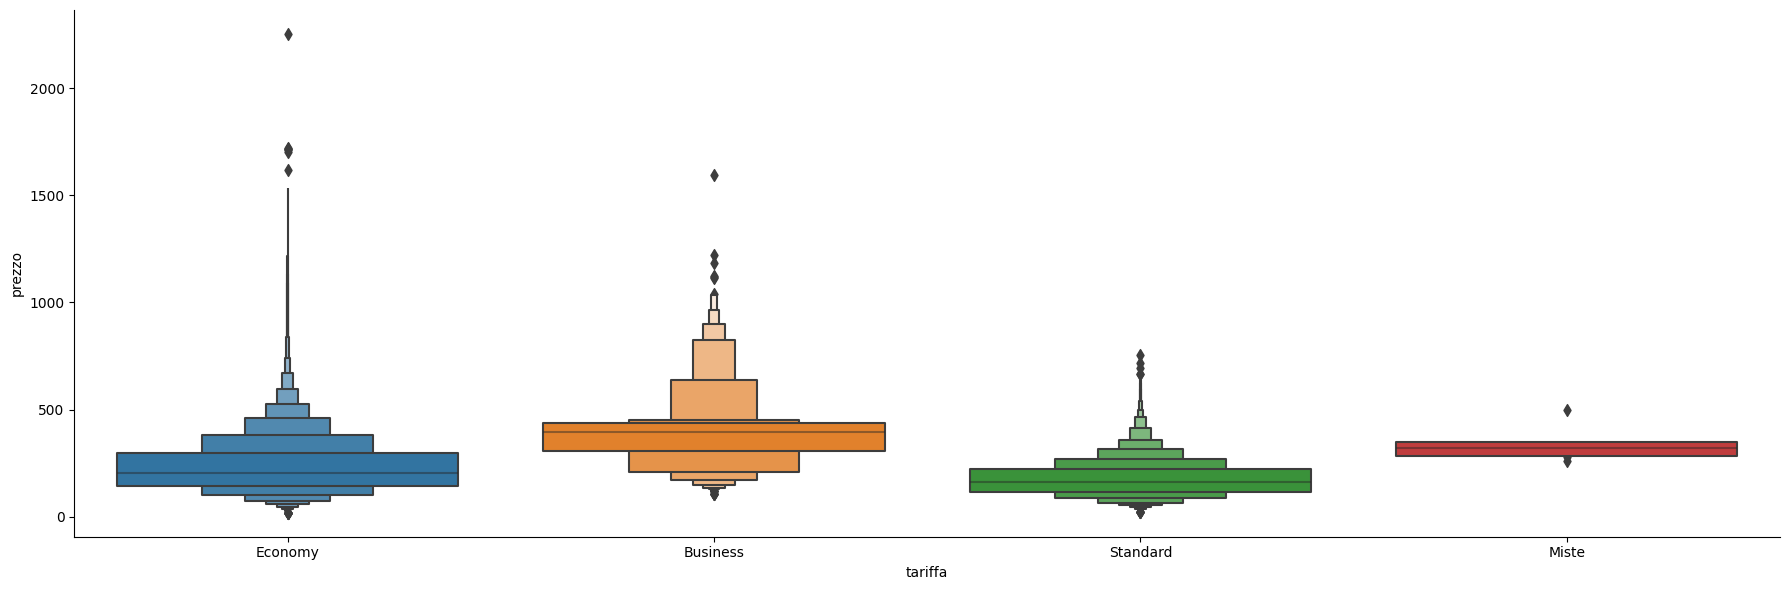

In [10]:
# tariff type vs price
sns.catplot(y = "prezzo", x= 'tariffa', data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 6, aspect = 3)

In [11]:
#dummies for the different tariff types
dummies_tariffa = pd.get_dummies(data['tariffa'], prefix='tariffa')

data = pd.concat([data, dummies_tariffa], axis=1)
data = data.drop('tariffa', axis=1)

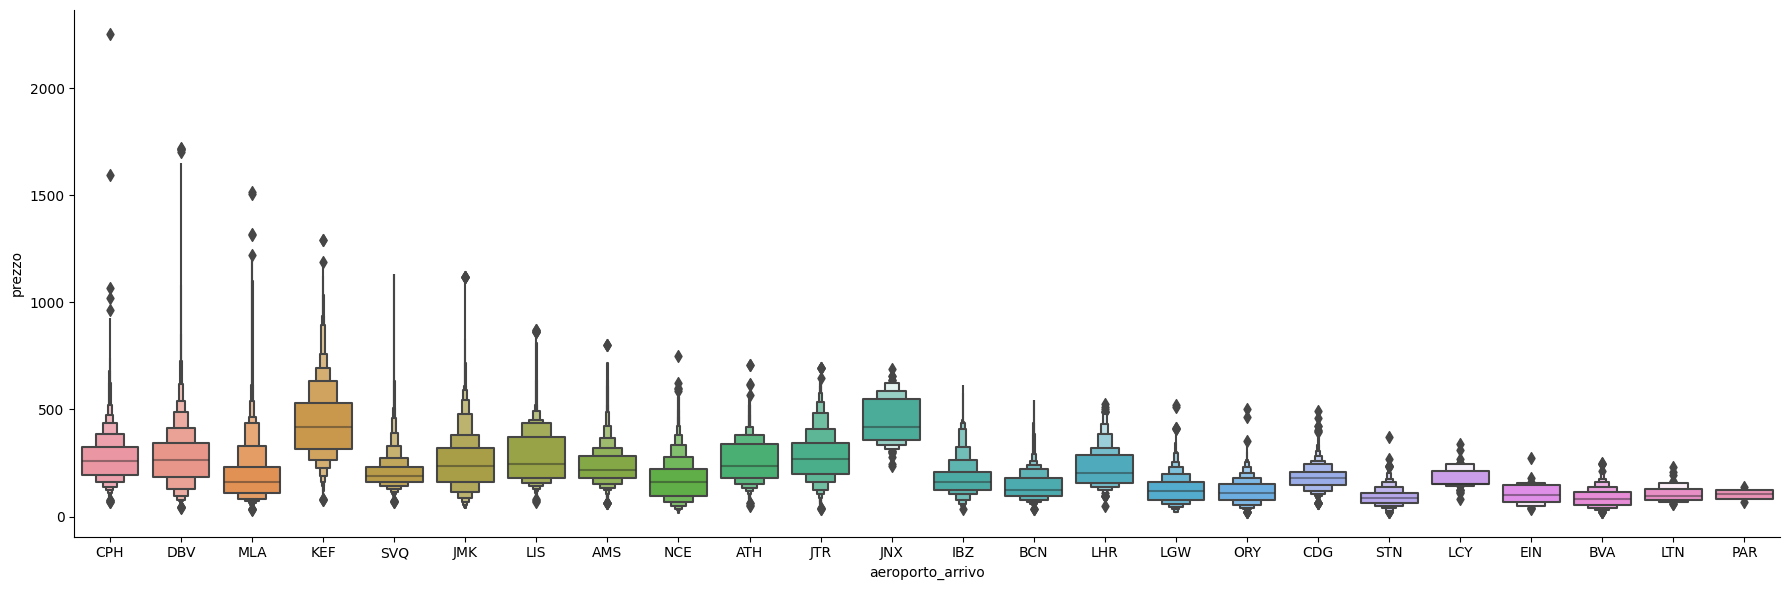

In [12]:
# destination vs price
sns.catplot(y = "prezzo", x= "aeroporto_arrivo", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 6, aspect = 3)

In [13]:
data['aeroporto_partenza'] = data['aeroporto_partenza'].replace({'ROM': 'FCO'})
dummies_aeroporto_partenza = pd.get_dummies(data['aeroporto_partenza'], prefix='aeroporto_partenza')


dummies_aeroporto_arrivo = pd.get_dummies(data['aeroporto_arrivo'], prefix='aeroporto_arrivo')
data = pd.concat([data, dummies_aeroporto_partenza, dummies_aeroporto_arrivo], axis=1)
data = data.drop(['aeroporto_partenza', 'aeroporto_arrivo'], axis=1)

# dummies_operatore = pd.get_dummies(data['operatore'], prefix='operatore')

# data = pd.concat([data, dummies_operatore], axis=1)
data['operatore'] = data['operatore'].replace({'easyJet Europe': 'easyJet'})
data['operatore'] = data['operatore'].replace({'Ryanair UK': 'Ryanair'})
data['operatore'] = data['operatore'].replace({'Transavia France': 'Transavia'})
data.loc[data['operatore'].str.contains(','), 'operatore'] = 'Multiple_Operator'

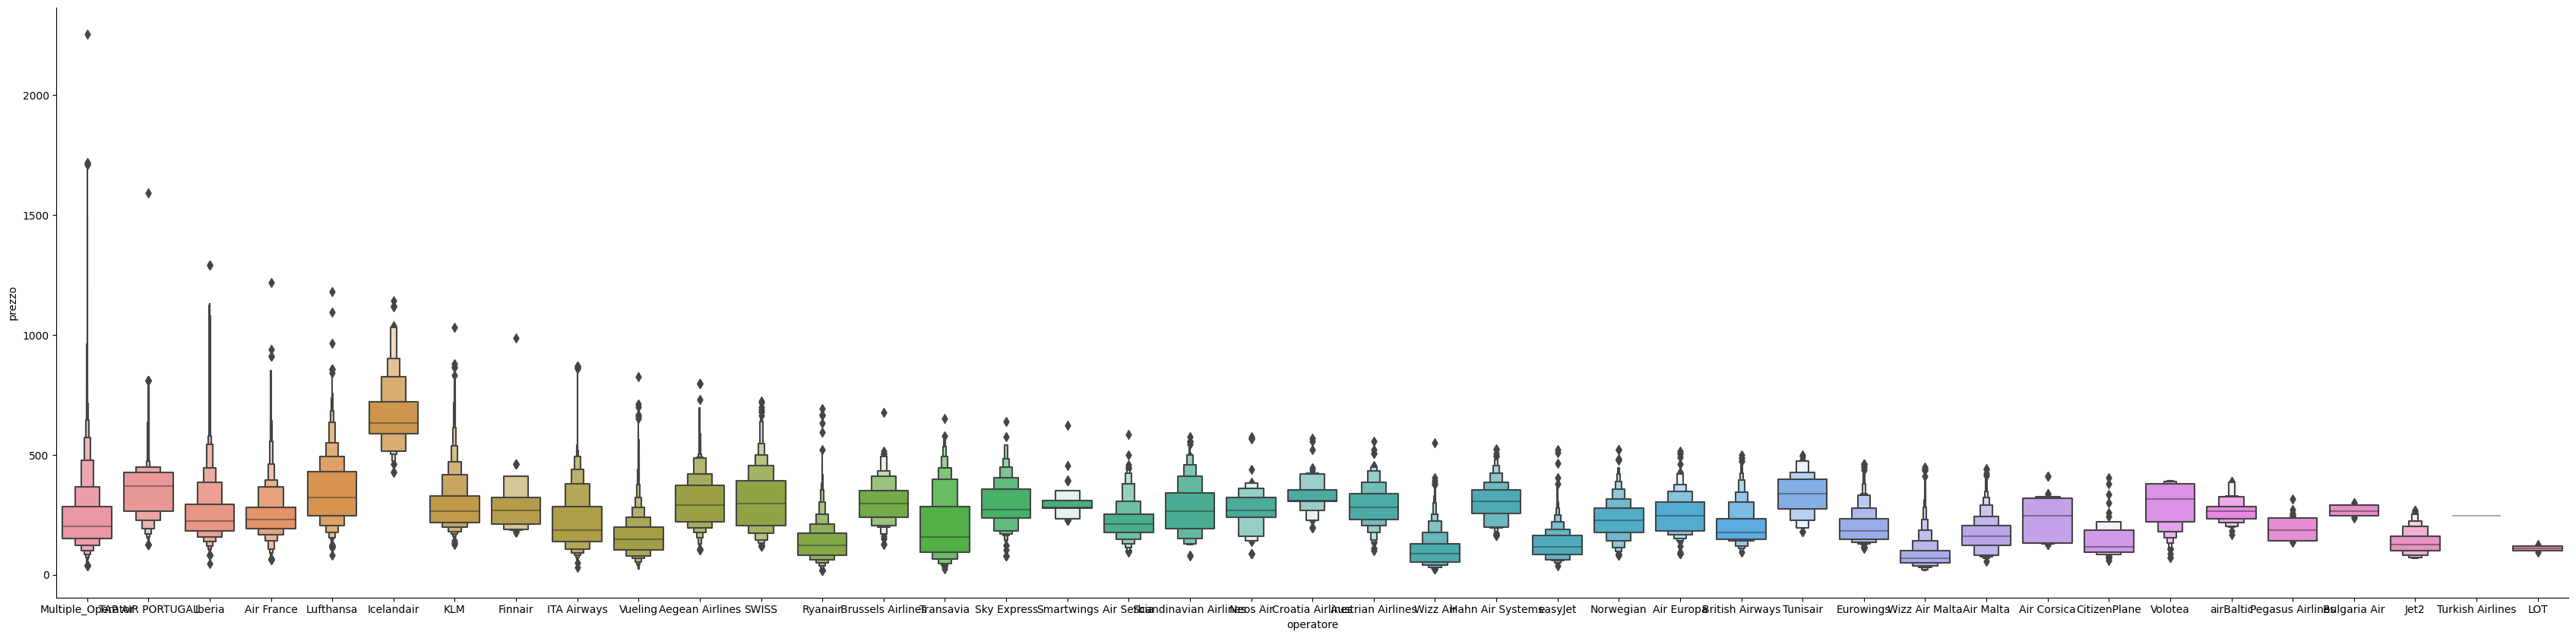

In [21]:
# flight operator vs price
sns.catplot(y = "prezzo", x= "operatore", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 8.5, aspect = 4)

In [22]:
dummy_operators = data['operatore'].str.get_dummies()
data = pd.concat([data, dummy_operators], axis=1)

data = data.drop('operatore', axis=1)

In [23]:
data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'], utc=True)

In [24]:

#data['orario_partenza'] = pd.to_datetime(data['orario_partenza'])
#data['orario_arrivo'] = pd.to_datetime(data['orario_arrivo'])


data['partenza_0-8'] = (data['orario_partenza'].dt.hour >= 0) & (data['orario_partenza'].dt.hour < 8)
data['partenza_8-16'] = (data['orario_partenza'].dt.hour >= 8) & (data['orario_partenza'].dt.hour < 16)
data['partenza_16-24'] = (data['orario_partenza'].dt.hour >= 16) & (data['orario_partenza'].dt.hour < 24)


data['arrivo_0-8'] = (data['orario_arrivo'].dt.hour >= 0) & (data['orario_arrivo'].dt.hour < 8)
data['arrivo_8-16'] = (data['orario_arrivo'].dt.hour >= 8) & (data['orario_arrivo'].dt.hour < 16)
data['arrivo_16-24'] = (data['orario_arrivo'].dt.hour >= 16) & (data['orario_arrivo'].dt.hour < 24)


data['partenza_0-8'] = data['partenza_0-8'].astype(int)
data['partenza_8-16'] = data['partenza_8-16'].astype(int)
data['partenza_16-24'] = data['partenza_16-24'].astype(int)

data['arrivo_0-8'] = data['arrivo_0-8'].astype(int)
data['arrivo_8-16'] = data['arrivo_8-16'].astype(int)
data['arrivo_16-24'] = data['arrivo_16-24'].astype(int)

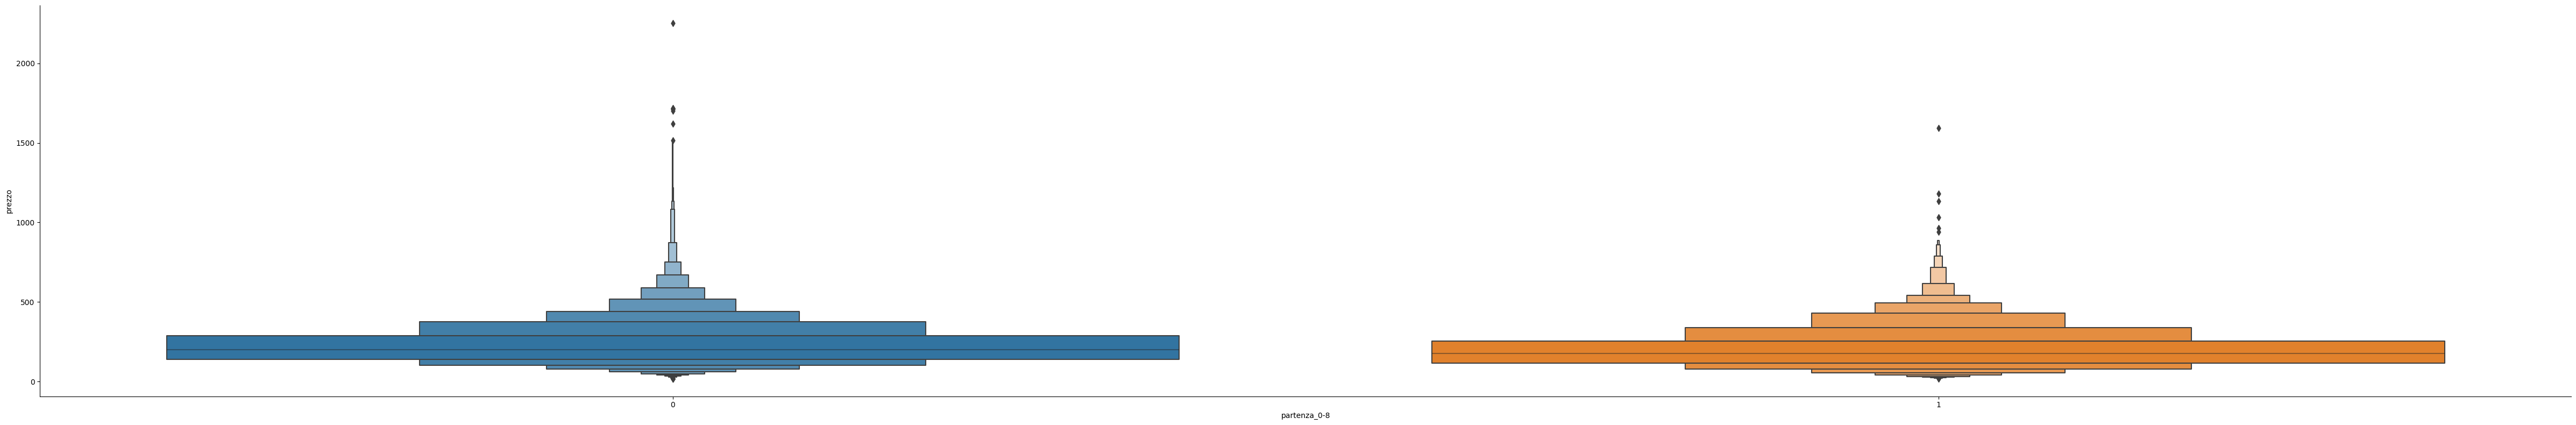

In [31]:
sns.catplot(y = "prezzo", x= 'partenza_0-8', data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 8, aspect = 6)

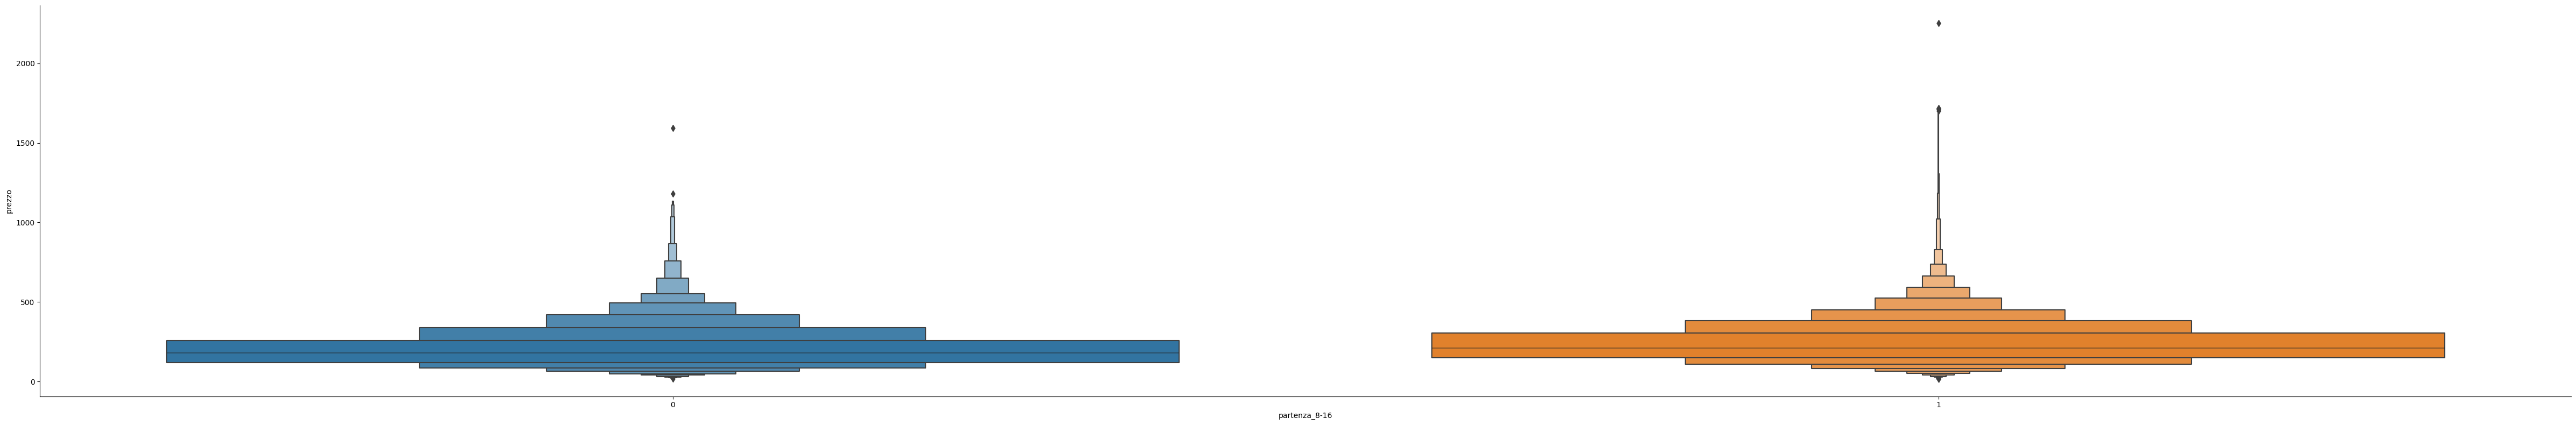

In [32]:
sns.catplot(y = "prezzo", x= 'partenza_8-16', data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 8, aspect = 6)

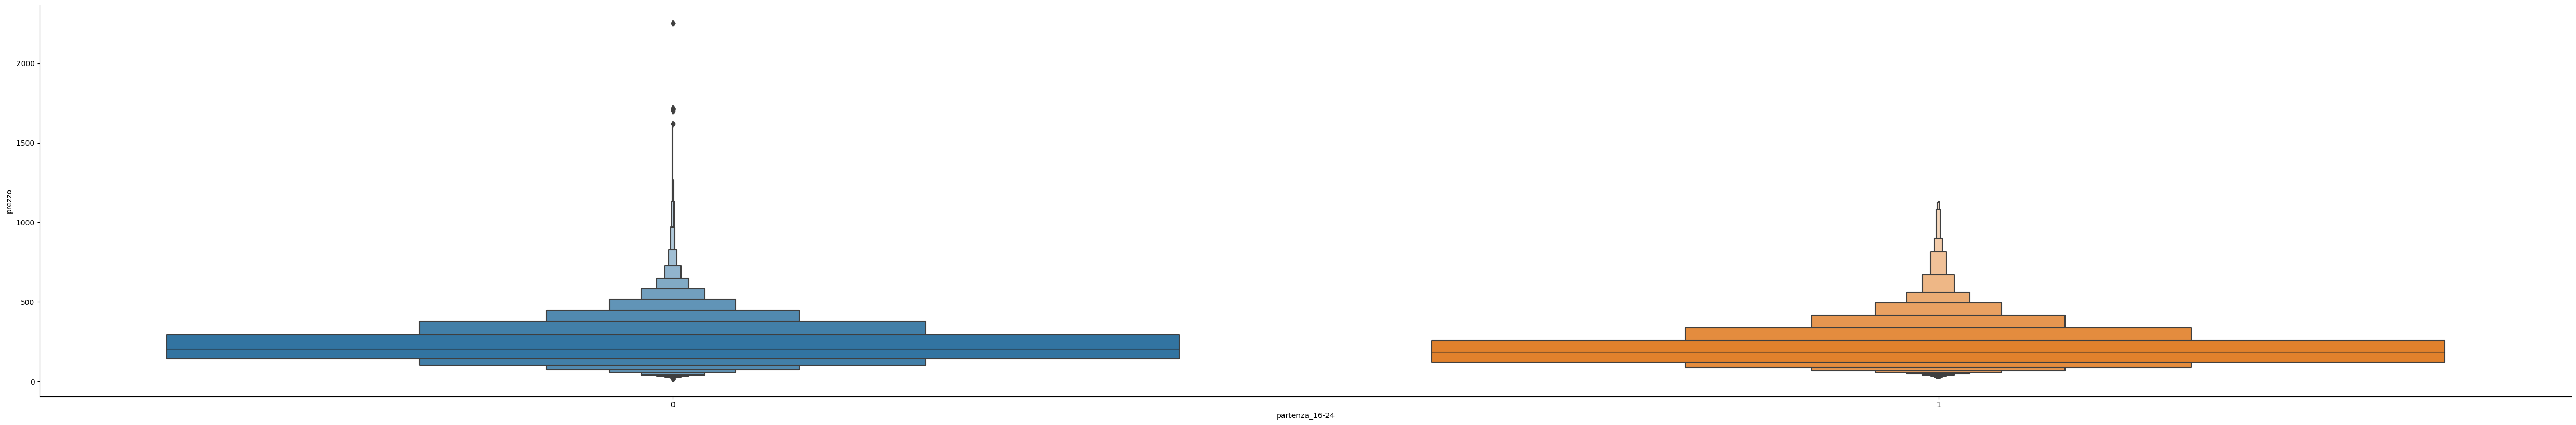

In [33]:
sns.catplot(y = "prezzo", x= 'partenza_16-24', data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 8, aspect = 6)

In [34]:
def map_numero_giorno(numero_giorno):
    if 24 <= numero_giorno <= 31:
        return 1
    elif 1 <= numero_giorno <= 7:
        return 2
    elif 8 <= numero_giorno <= 15:
        return 3
    else:
        return None 

data['giorno_settimana'] = data['data_partenza'].apply(lambda x: x.split()[0])
data['numero_giorno'] = data['data_partenza'].apply(lambda x: int(x.split()[1].split('/')[0]))
data['numero_mese'] = data['data_partenza'].apply(lambda x: int(x.split('/')[1]))

data['colonna_personalizzata'] = data['numero_giorno'].apply(map_numero_giorno)

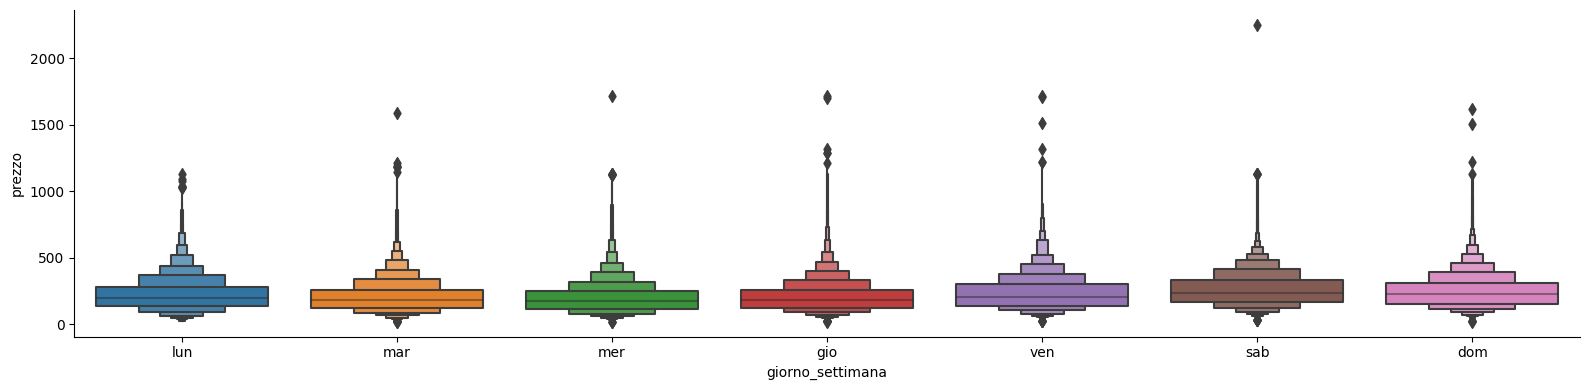

In [35]:
# day of the week vs price, fai anche per il resto
sns.catplot(y = "prezzo", x= "giorno_settimana", data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 4, aspect = 4, order=['lun','mar','mer','gio','ven','sab','dom'])

In [36]:
giorno_settimana_dummy = pd.get_dummies(data['giorno_settimana'])
settimana_dummy = pd.get_dummies(data['colonna_personalizzata'], prefix='settimana')
mese_dummy = pd.get_dummies(data['numero_mese'], prefix='mese')


data = pd.concat([data, giorno_settimana_dummy, settimana_dummy, mese_dummy], axis=1)


data.drop(['giorno_settimana', 'numero_giorno', 'numero_mese', 'colonna_personalizzata'], axis=1, inplace=True)

In [37]:
df = pd.DataFrame(data)
# Funzione per convertire il formato delle date nella colonna 'data_ril'
def converti_data(data):
    giorni_settimana = {'lun': 'Mon', 'mar': 'Tue', 'mer': 'Wed', 'gio': 'Thu', 'ven': 'Fri', 'sab': 'Sat', 'dom': 'Sun'}
    for giorno in giorni_settimana:
        data = data.replace(giorno, giorni_settimana[giorno])

    data = data.replace('\\', '/').replace('\'', '')
    return data

# Funzione per estrarre solo il formato '24/7' dalla colonna 'data_partenza'
def estrai_data_partenza(data):
    return data.split()[1]

# Applica le funzioni alle colonne 'data_partenza' e 'data_ril' del DataFrame 'data'
data['data_partenza'] = data['data_partenza'].apply(estrai_data_partenza)
data['data_ril'] = data['data_ril'].apply(converti_data)

def calculate_date_difference(date_partenza, date_rilevato):
    
    if date_partenza is None or date_rilevato is None:
        return None

    
    date_partenza_obj = datetime.strptime(date_partenza, '%d/%m')
    date_rilevato_obj = datetime.strptime(date_rilevato, '%d/%m')

    
    diff_days = (date_rilevato_obj.replace(year=date_partenza_obj.year) - date_partenza_obj).days

    return abs(diff_days) 

# data['data_partenza'] = data['data_partenza'].apply(format_date_partenza)
# data['data_ril'] = data['data_ril'].apply(format_date_rilevato)


data['differenza_giorni'] = data.apply(lambda row: calculate_date_difference(row['data_partenza'], row['data_ril']), axis=1)

conteggio_celle_vuote = data['differenza_giorni'].isnull().sum()

print("Numero di celle vuote nella colonna 'differenza_giorni':", conteggio_celle_vuote)


Numero di celle vuote nella colonna 'differenza_giorni': 0


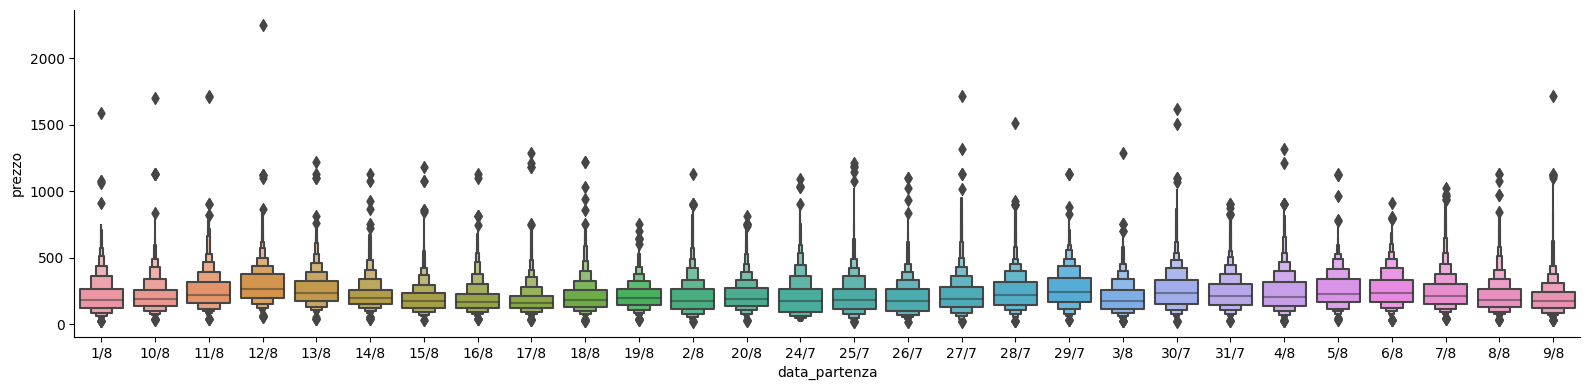

In [38]:
# departure date vs price, fai anche per il resto
date = list(data['data_partenza'].sort_values().unique())
sns.catplot(y = "prezzo", x= 'data_partenza', data = data.sort_values("prezzo", ascending = False), kind="boxen", height = 4, aspect = 4, order = date)

In [39]:
thresholds = [1, 3, 7, 15, 30, 60]

data['interval'] = pd.cut(data['differenza_giorni'], bins=[0] + thresholds + [float('inf')])

dummy_columns = pd.get_dummies(data['interval'], prefix='Differenza')

data = pd.concat([data, dummy_columns], axis=1)

In [40]:
data = data.drop('orario_partenza', axis=1)
data = data.drop('interval', axis=1)
data = data.drop('orario_arrivo', axis=1)
data = data.drop('data_ril', axis=1)
data = data.drop('data_partenza', axis=1)
output_file = "Voli1.xlsx"
data.to_excel(output_file, index=False)

Once we have build our dataset we can start to analyze it further.

Following stesps:
* Outliers removal
* data visualization
* diagnostic 
* features selection

## Outliers removal


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
import random                                    
from math import isnan
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
import re
import os


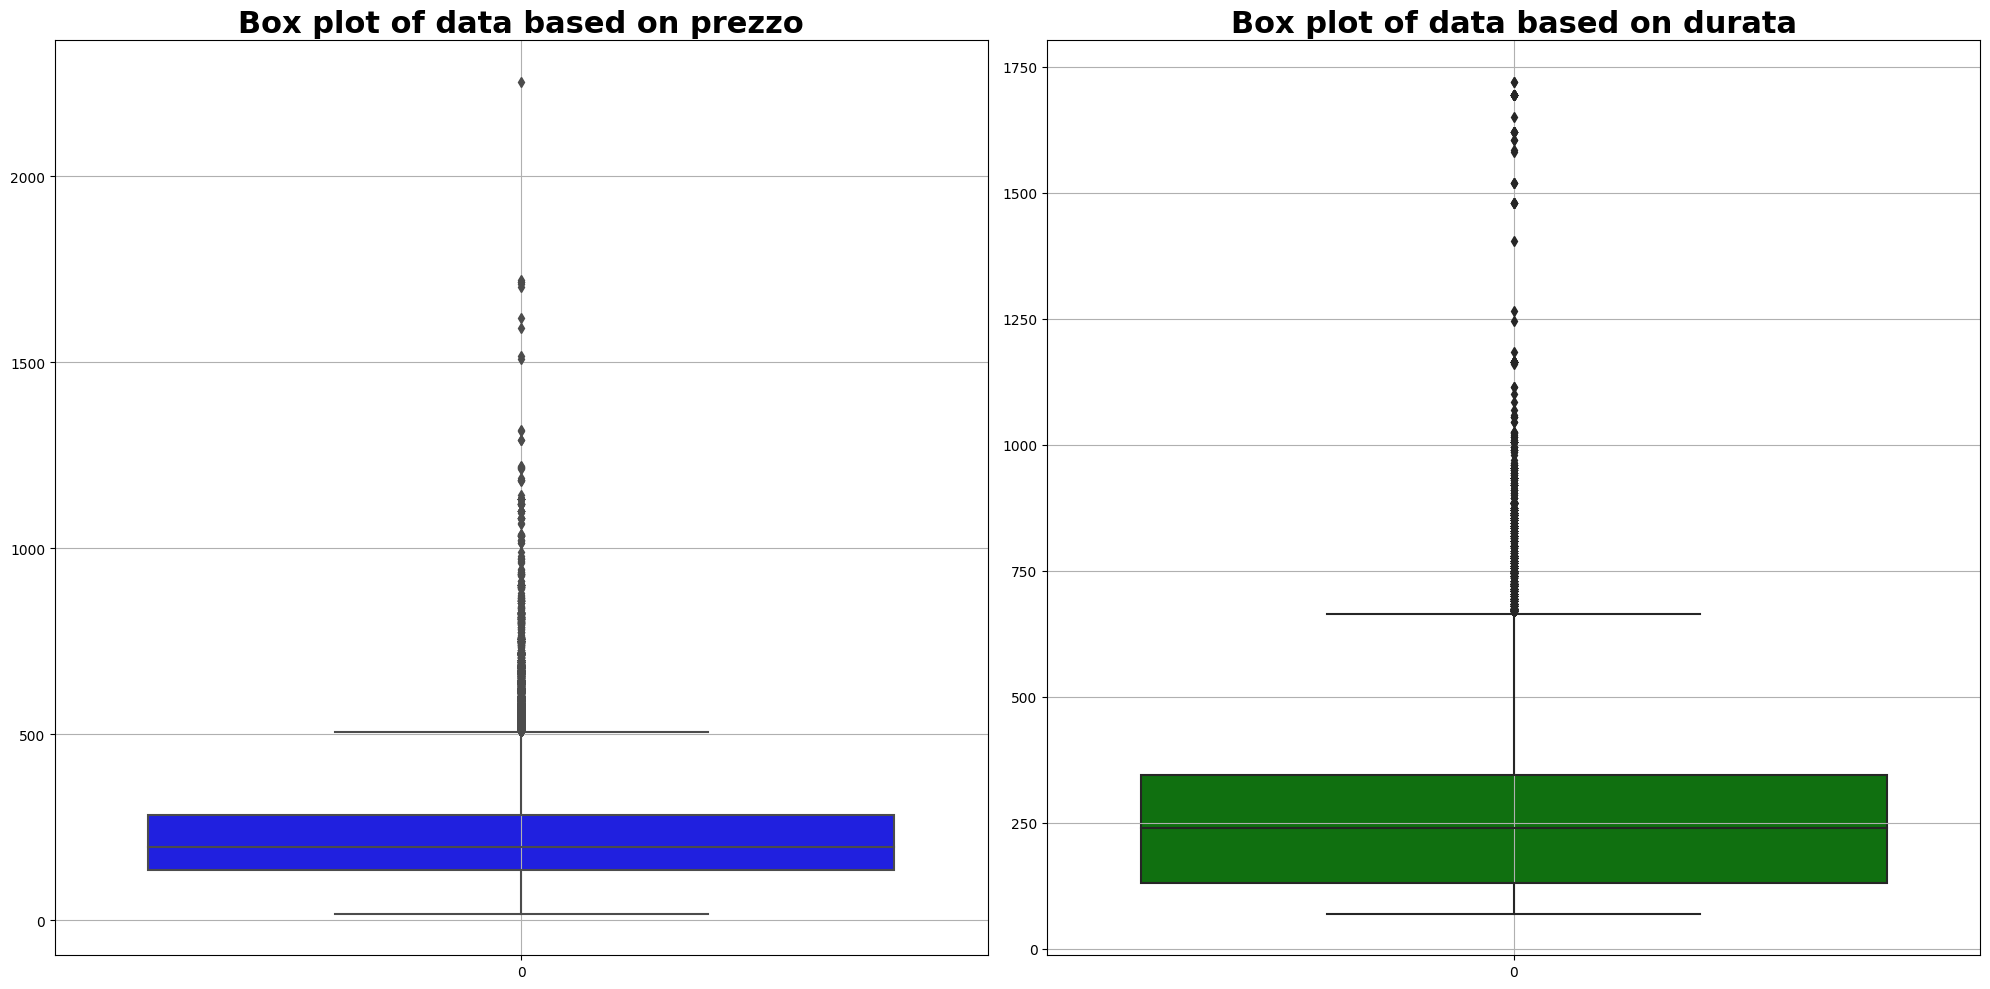

In [6]:
# Box-plots of some principal, non-binary, features. As already seen, on the right side of the plots we notice several outliers
data = pd.read_excel('Voli1.xlsx')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
features = ['prezzo','durata']
colors = ['b', 'g'] #['b', 'g', 'm', 'c', 'r']
for row_idx in range(1):
    k = row_idx
    for col_idx in range(2): 
        current = axes[col_idx]
        target = col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [7]:
upper_bound_price = np.percentile(data.loc[:, 'prezzo'], 95)
upper_bound_dimension = np.percentile(data.loc[:, 'durata'], 95)

# We now drop some of the outliers (the 5% with the highest dimensions and prices)

for i in data.index:
    if data.loc[i, 'prezzo'] > upper_bound_price:
        data = data.drop(i)
        continue
    if data.loc[i, 'durata'] > upper_bound_dimension:
        data = data.drop(i)

In [8]:
# Since we still have outliers, which could compromise our model performances, we proceed with a log-normalization of data
# APPLICATION OF LOG NORMALIZATION

for j in data.columns:  
    if set(data.loc[:, j]) != {0,1}:
        for i in data.index: 
                try:
                    data.loc[i, j] = np.sign(data.loc[i,j]) * np.log(np.absolute(data.loc[i, j]) + 1 )
                except:
                    continue

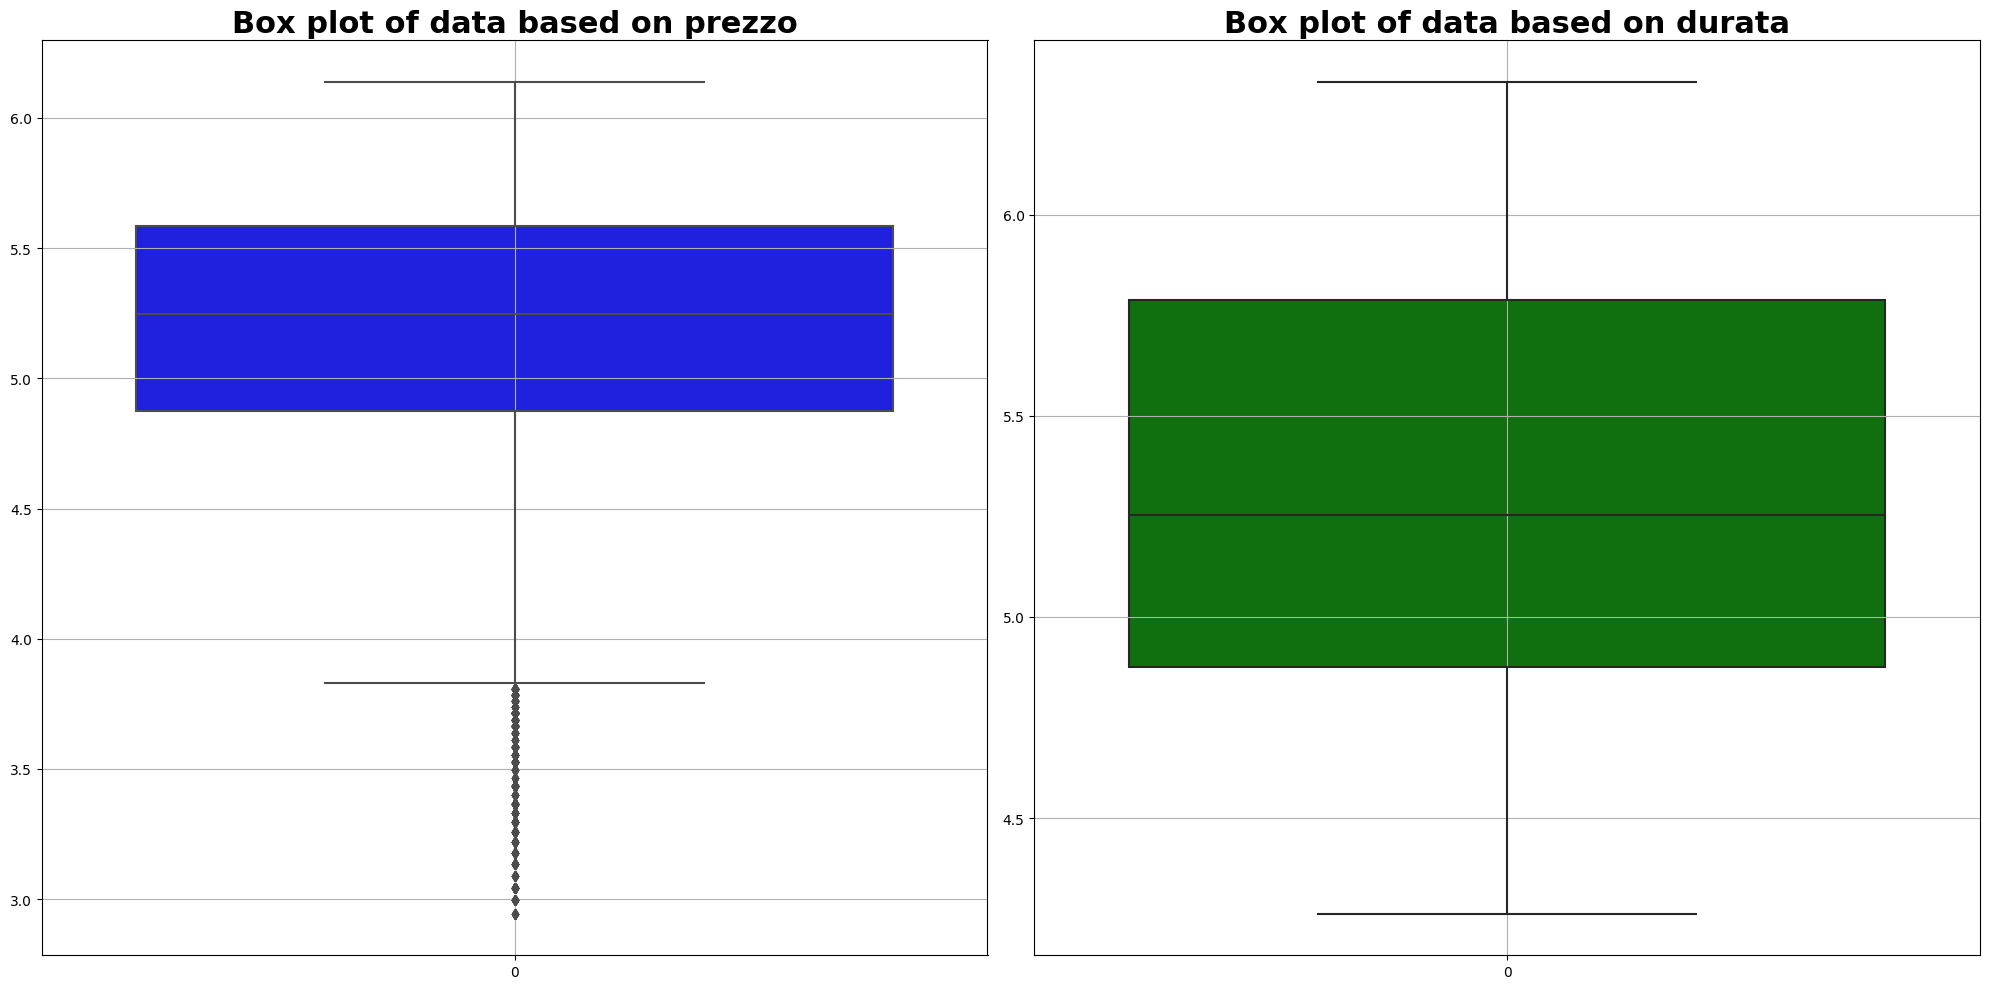

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))
features = ['prezzo','durata']
colors = ['b', 'g'] #['b', 'g', 'm', 'c', 'r']
for row_idx in range(1):
    k = row_idx
    for col_idx in range(2): 
        current = axes[col_idx]
        target = col_idx + k
        
        if target == 5:
            continue
        
        featureName = features[target]

        sns.boxplot(data.loc[:, featureName], ax = current, color = colors[target])
        

        current.set_title(f"Box plot of data based on {featureName}", fontweight = "bold", fontsize = 22 )
        current.grid()
        
fig.tight_layout()

In [10]:
# Calcolare la matrice di correlazione
correlation_matrix = data[['prezzo', 'durata', 'distanza']].corr()

# Stampa la matrice di correlazione
print(correlation_matrix)


            prezzo    durata  distanza
prezzo    1.000000  0.311349  0.126686
durata    0.311349  1.000000  0.255563
distanza  0.126686  0.255563  1.000000


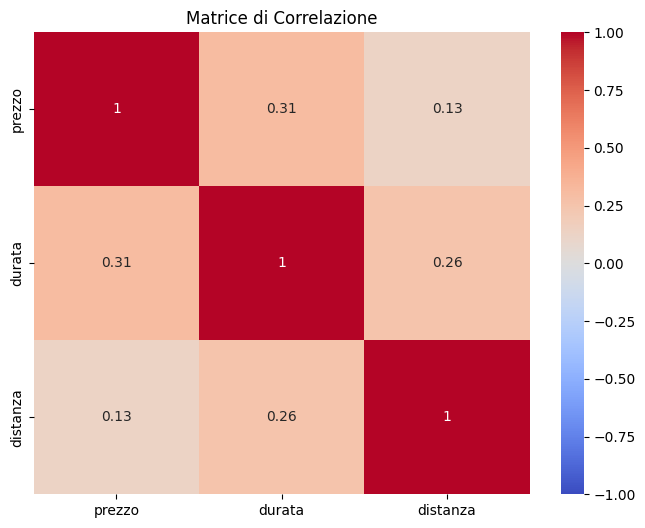

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Creare la heatmap della matrice di correlazione
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matrice di Correlazione')
plt.show()

In [57]:
def get_column_names(file_name):
    try:
       
        df = pd.read_excel(file_name)
        column_names = df.columns.tolist()
        return column_names

    except Exception as e:
        print("Si è verificato un errore:", str(e))
        return []

file_path = "Voli1.xlsx"

column_names_list = get_column_names(file_path)

print("Nomi delle colonne:", column_names_list)


Nomi delle colonne: ['tipo', 'durata', 'prezzo', 'distanza', 'tariffa_Business', 'tariffa_Economy', 'tariffa_Miste', 'tariffa_Standard', 'aeroporto_partenza_CIA', 'aeroporto_partenza_FCO', 'aeroporto_arrivo_AMS', 'aeroporto_arrivo_ATH', 'aeroporto_arrivo_BCN', 'aeroporto_arrivo_BVA', 'aeroporto_arrivo_CDG', 'aeroporto_arrivo_CPH', 'aeroporto_arrivo_DBV', 'aeroporto_arrivo_EIN', 'aeroporto_arrivo_IBZ', 'aeroporto_arrivo_JMK', 'aeroporto_arrivo_JNX', 'aeroporto_arrivo_JTR', 'aeroporto_arrivo_KEF', 'aeroporto_arrivo_LCY', 'aeroporto_arrivo_LGW', 'aeroporto_arrivo_LHR', 'aeroporto_arrivo_LIS', 'aeroporto_arrivo_LTN', 'aeroporto_arrivo_MLA', 'aeroporto_arrivo_NCE', 'aeroporto_arrivo_ORY', 'aeroporto_arrivo_PAR', 'aeroporto_arrivo_STN', 'aeroporto_arrivo_SVQ', 'Aegean Airlines', 'Air Corsica', 'Air Europa', 'Air France', 'Air Malta', 'Air Serbia', 'Austrian Airlines', 'British Airways', 'Brussels Airlines', 'Bulgaria Air', 'CitizenPlane', 'Croatia Airlines', 'Eurowings', 'Finnair', 'Hahn Air

In [52]:
data.memory_usage(deep=True)

Index            2665008
tipo              551432
durata            551432
prezzo            551432
data_partenza    4182297
                  ...   
diff_3            551432
diff_4            551432
diff_5            551432
diff_6            551432
diff_7            551432
Length: 104, dtype: int64

The previous graghs may not seem very informative in case of binary variables. Thus it could be more useful to show the violin plot of our variable of interest 'Prezzo' with respect to some of our binary features.

Features Selection

In [13]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X = data.drop(columns=['prezzo']) 
y = data['prezzo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

alpha = 1.0  
ridge_model = Ridge(alpha=alpha)

ridge_model.fit(X_train, y_train)

print("Coefficienti del modello Ridge:")
print(ridge_model.coef_)

feature_importance = np.abs(ridge_model.coef_)

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\nImportanza delle features:")
print(feature_importance_df)


test_score = ridge_model.score(X_test, y_test)
print("\nR^2 score sul test set:", test_score)

Coefficienti del modello Ridge:
[ 0.02529115  0.1083816  -0.20525993  0.27769944 -0.04496048 -0.01430963
 -0.21842933  0.0076403  -0.0076403   0.12718711  0.20102991 -0.21477281
 -0.47016649 -0.13239073  0.32284974  0.00211132 -0.11159046  0.00300877
  0.25654354  0.65568321  0.3460188   0.88060821 -0.14629137 -0.23207282
 -0.0120812   0.35590041 -0.34049802 -0.11045888 -0.40253712 -0.24301573
 -0.45891768 -0.48755428  0.21140657  0.11702105  0.23670112 -0.08758204
  0.30513016 -0.18744951 -0.14831771  0.1378065   0.21327924  0.29955736
 -0.06866719 -0.18546729  0.29136052 -0.32598801 -0.26201809  0.15136504
  0.03347964  0.39085389 -0.03661573  0.06793001  0.20871762 -0.36003718
  0.2424952  -0.13082837  0.11203289 -0.12720656 -0.25544853 -0.16047792
  0.15112963 -0.10057949  0.05024059  0.24821276  0.23022802 -0.12865896
  0.54165106  0.00269063  0.2583194  -0.23954775 -0.65510118 -0.80018006
  0.03131131 -0.06134208 -0.08357092  0.06323923  0.02033169 -0.09656672
  0.06897797  0.027

In [ ]:
price = data['prezzo']
feat = data.copy()
feat = feat.drop(['prezzo'], axis = 1)

In [21]:
from sklearn.feature_selection import SelectKBest, f_regression

# Creazione di un oggetto SelectKBest con il metodo di valutazione f_regression, F-value between label/feature for regression tasks.
selector = SelectKBest(score_func=f_regression, k=5)

# Applicazione della feature selection ai dati
X_selected = selector.fit_transform(feat, price)

# Ottenere le feature selezionate
selected_indices = selector.get_support(indices=True)
selected_features = feat.columns[selected_indices]


LOCO based on Random Forest Regressor

In [5]:
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import metrics

var_list = feat.columns
loco_res = {}
# Numero di bootstrap samples
n_bootstrap_samples = 20 #era 100, magari fare una prova con altri valori 50, 10 etc
# Livello di significatività desiderato
alpha = 0.05
#var_imp --> list of var, take first 10

for feature in var_list:
    loco_scores = []
   
    for _ in tqdm(range(n_bootstrap_samples)): 
        X_train_loco, X_test_loco, y_train_loco, y_test_loco = train_test_split(feat,price, test_size=0.2) #Randomly split the training data into two, non overlapping, parts
        
        reg = RandomForestRegressor() #Run any algorithm you like to compute an estimate fn1 (·) on first part Dn1 .
        reg.fit(X_train_loco, y_train_loco)
        y_pred_loco = reg.predict(X_test_loco)
        baseline_metric = r2_score(y_test_loco, y_pred_loco)
        
        # Temporarily remove the current feature
        X_train_loco = X_train_loco.drop(feature, axis=1)
        X_test_loco = X_test_loco.drop(feature, axis=1)
        
        # Retrain the model on the modified dataset
        reg_temp = RandomForestRegressor()
        reg_temp.fit(X_train_loco, y_train_loco)
        # Make predictions on the modified dataset
        y_pred_temp = reg_temp.predict(X_test_loco)
        # Compute the r2_score and LOCO score
        metric_temp = r2_score(y_test_loco, y_pred_temp)
        loco_score = metric_temp - baseline_metric #def (l^-j - l) for each j in first_10  #devo mettere median qui?
        loco_scores.append(loco_score)
        
        
    loco_res[feature] = loco_scores #100 theta_j for each j 


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Lista per memorizzare gli intervalli di confidenza delle mediane
#n_bootstrap_samples = 100
#alpha = 0.05
confidence_intervals = []
store = []
for elem in var_list:

    # Campione di loco scores
    bootstrap_loco = loco_res[elem]

    # Calcolo dell'intervallo di confidenza corretto di Bonferroni
    sorted_loco = np.sort(bootstrap_loco)
    store.append(np.median(sorted_loco))
    
    lower_bound = sorted_loco[int(10 * alpha / 2)] #credo che al posto di 10 vada in numero di variabili che stiamo analizzando
    upper_bound = sorted_loco[int(10 * (1 - alpha / 2))]# idem di quello sopra
    
    # Aggiunta dell'intervallo di confidenza alla lista
    confidence_intervals.append((round(lower_bound,4), round(upper_bound,4)))

# Stampa degli intervalli di confidenza corretti di Bonferroni per ciascuna variabile   #ritornare il nome della variabile
for i, interval in enumerate(confidence_intervals):
    print('-'*90)
    print(f'Variabile', var_list[i],': '+'confidence interval =', interval, ', LOCO score', round(store[i],4)) 
    #print(f"Variabile {i+1}: confidence interval = {interval}")
print('-'*90)

In [ ]:
#Using Pearson Correlation
cor = X_train.corr()
plt.figure(figsize=(12,10))
sns.heatmap(cor, cmap=plt.cm.CMRmap_r,annot=True)
plt.show()

#Finding the correlated features
def correlation(dataset, threshold):
    col_corr = set()  
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: colname = corr_matrix.columns[i]
            col_corr.add(colname)
    return col_corr 

With the help of this function, we can select highly correlated features. The purpose is to select the correlated features and then remove them. If you note then we have written abs means absolute, because we will get a negative correlation also which will convert into a positive.

In [ ]:
#Removing correlated features
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)
X_train 

Chi-square is used to find F-score and p-values for all features. So in this case the first array is for F score and the second array is for p- values. Now, what is the importance of these two values? And the more the value of the F score the more important the feature is and the lesser the value of the p-value the more important will be the feature.

In [ ]:
#Chi-square
#Perform chi2 test
from sklearn.feature_selection import chi2
Calculating Fscore and p value
f_p_values=chi2(X_train,y_train)
F_p_values

In [ ]:
#Representing in list form
import pandas as pd
p_values=pd.Series(f_p_values[1])
p_values.index=X_train.columns
P_values        
#Sorting values in ascending order
p_values.sort_index(ascending=False)

In [ ]:
#Now let’s learn the third very important technique i.e feature selection by using mutual information gain.
#Mutual information gain
#Importing mutual information gain
from sklearn.feature_selection import mutual_info_classif
# determine the mutual information
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

#plot the ordered mutual_info values per feature
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 8))


mutual_info_classif is a library that is present in feature_selection. It is the property of mutual information gain that the value you will get will never be negative. The higher the value the more important that feature will be or you can say that the dependency of that independent feature will be more on the dependent feature.

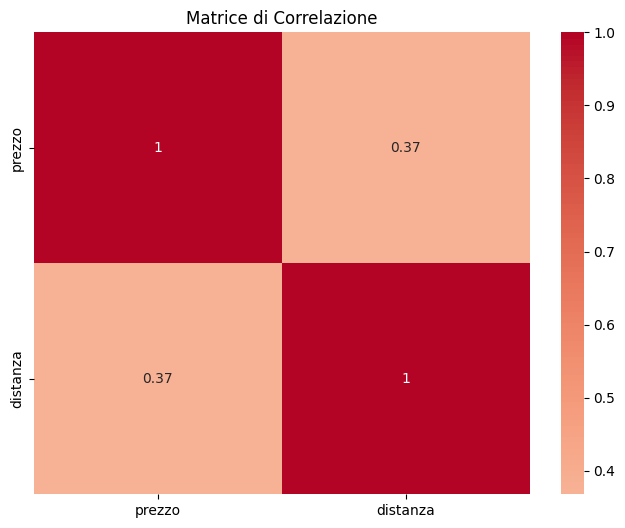

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

#correlation matrix excluding categorical variables
sub_data = pd.DataFrame(index=data.index, columns=['prezzo','distanza'])
sub_data['prezzo'] = data['prezzo']
sub_data['distanza'] = data['distanza']

# Calcola la matrice di correlazione
correlation_matrix = sub_data.corr()

# Crea una mappa di calore della matrice di correlazione
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.show()


In [ ]:
# Checking for Multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(z):
    # Calculating Variable Inflation Factor (VIF)
    vif = pd.DataFrame()
    vif["variables"] = z.columns
    vif["VIF"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
    return(vif)

# Compute VIF on X
calc_vif(X)

In [7]:
#identify input features X and response y

y = data.loc[:, 'prezzo'].values.astype('float64')

X_temp = data.copy()

X_temp = X_temp.drop(['prezzo'], axis = 1)
col_ind = list(X_temp.columns)

X = X_temp.values.astype('float64')

In [8]:
from sklearn.model_selection import train_test_split
#defining train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
# We built from scratch the GCV and LOOCV cross validation, magari possiamo usarle al posto della semplice cross validation

def GCV(mse, d, n):
    return mse/(1-(d+1)/n)**2
def LOOCV(M, true_y, pred_y):
    H = M @ np.linalg.inv(M.T@M) @ M.T
        
    L = (1/(M.shape[0]))*sum(  ((true_y[i]-pred_y[i])/(1-H[i][i]))**2      for i in range(M.shape[0])  ) 
    
    return L


In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import cross_val_score

cv_lin_reg = LinearRegression()

# Valutazione del modello con cross-validation
#scorer = make_scorer(r2_score, greater_is_better=True) # Defining the scorer, r^2 già quello di default
scores = cross_val_score(cv_lin_reg, X, y, scoring=scorer, cv=10)  # 5-fold cross-validation
print("Punteggi cross-validation:", scores)
print("Media punteggi:", np.mean(scores))


lin_reg = LinearRegression()
#fit the model
lin_reg.fit(X_train, y_train)
#make prediction
y_pred_lin = lin_reg.predict(X_test)

#regression coefficients
lin_reg_coef = lin_reg.coef_ 
#print(lin_reg.coef_) 

Punteggi cross-validation: [ 0.28858119  0.54560028  0.33765246  0.42427656  0.4132756   0.07610451
  0.49009882 -0.75966541  0.77283294  0.61518126]
Media punteggi: 0.32039382042694464


In [29]:
# evaluation of performance metrics

#R^2:
score_lin_reg = r2_score(y_test, y_pred_lin)
print(score_lin_reg)

#RMSE:
lin_reg_rmse = mean_squared_error(y_test, y_pred_lin, squared=False)
print(lin_reg_rmse)

0.6462253108586811
71.92035364738825


creare un grafico che ti aiuti a visualizzare i risultati della validazione incrociata e a valutare le prestazioni del modello utilizzando Python e librerie come scikit-learn e matplotlib.

La validazione incrociata è una tecnica utilizzata per stimare le prestazioni di un modello su dati non visti durante l'addestramento. Uno dei modi più comuni per farlo è la "K-Fold Cross-Validation", in cui il set di dati viene suddiviso in K parti uguali (fold), il modello viene addestrato su K-1 fold e testato sull'ultimo fold, ripetendo il processo K volte.

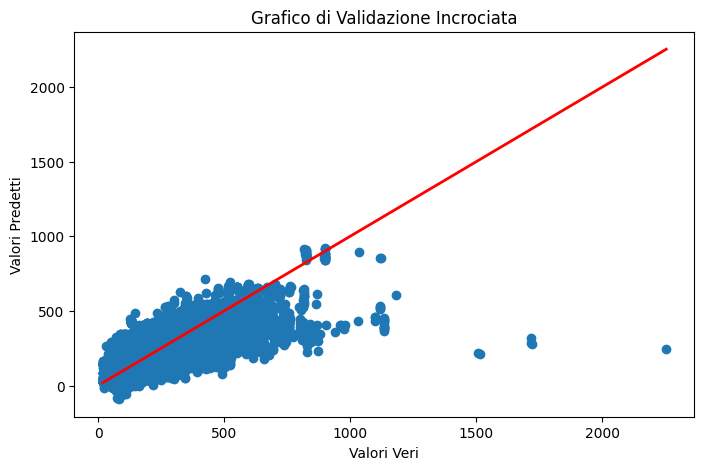

In [30]:
from sklearn.model_selection import cross_val_predict
# Predizioni attraverso Cross-Validation

y_pred_cv = cross_val_predict(cv_lin_reg, X, y, cv=10)  # cv indica il numero di fold

# Creazione del grafico ????
plt.figure(figsize=(8, 5))
plt.scatter(y, y_pred_cv)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linewidth=2)  # Linea ideale
plt.xlabel("Valori Veri")
plt.ylabel("Valori Predetti")
plt.title("Grafico di Validazione Incrociata")
plt.show()


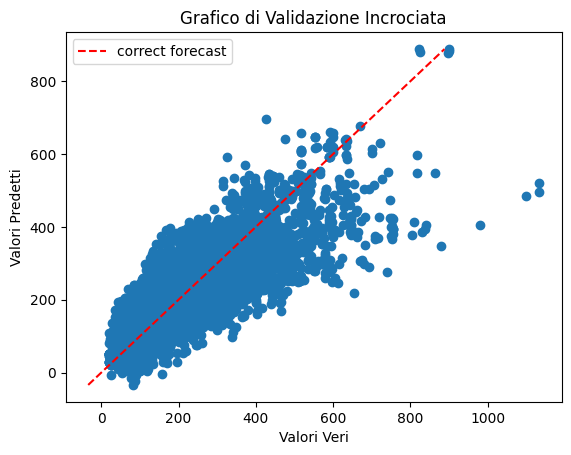

In [31]:
# PLOTTING RESULTS. Since the model is a multi-variate regression, if we want to visualize the results 
# we need to make a two-dimensional plot of points whose coordinates are (y_test , y_hat). 
# The more the points will be next to the y = x line, the more the predictor will be precise.

plt.scatter((y_test), (y_pred_lin))

x = np.arange(min((y_pred_lin)), max((y_pred_lin)))
plt.plot(x, x, '--', c = 'r', label = 'correct forecast')
plt.xlabel("Valori Veri")
plt.ylabel("Valori Predetti")
plt.title("Grafico di Validazione Incrociata")
plt.legend()

plt.show()

Residui Analisys 

catter Plot dei Residui: Questo è un grafico che mostra i residui (differenze tra i valori osservati e i valori predetti dal modello) rispetto ai valori predetti. Se i residui sono distribuiti casualmente intorno allo zero senza un modello evidente, il tuo modello potrebbe essere appropriato.

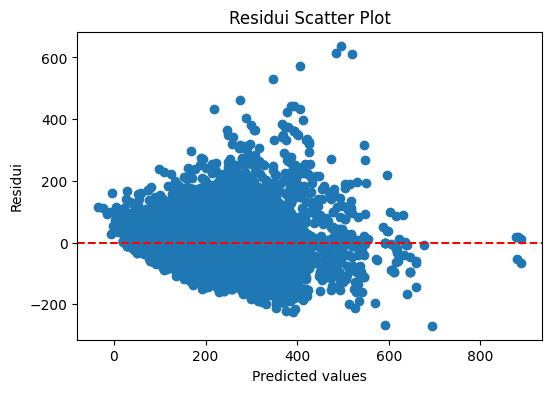

In [17]:
# residui scatterplot

residui = y_test - y_pred_lin # compute residui 

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_lin, residui)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residui")
plt.title("Residui Scatter Plot")
plt.show()

Un Q-Q Plot (Quantile-Quantile Plot) è un tipo di grafico utilizzato per confrontare la distribuzione dei quantili di due insiemi di dati. In pratica, viene utilizzato per verificare se due insiemi di dati seguono approssimativamente la stessa distribuzione o se ci sono deviazioni significative. Se i punti sul Q-Q Plot seguono approssimativamente una retta, ciò suggerisce che i dati seguono approssimativamente la distribuzione specificata (nel nostro caso, una distribuzione normale). Se i punti deviano significativamente dalla retta, potrebbe indicare deviazioni dalla distribuzione teorica.

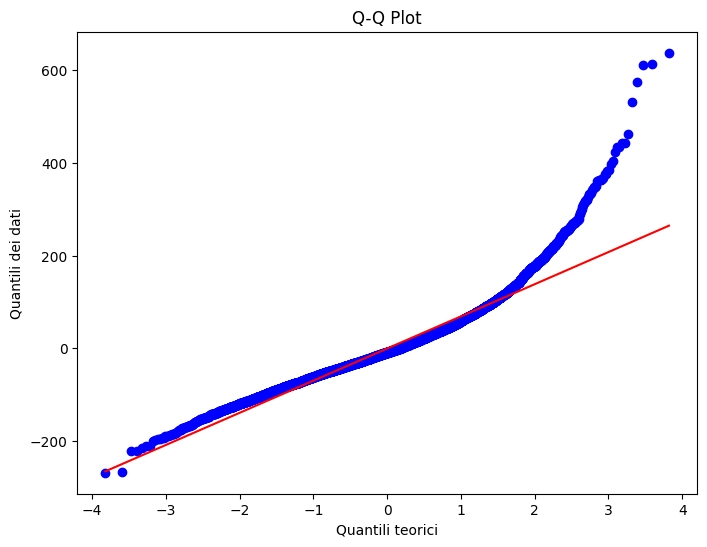

In [29]:
import scipy.stats as stats

# Creazione del Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residui, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.xlabel("Quantili teorici")
plt.ylabel("Quantili dei dati")
plt.show()
#il fatto che devi poi identifica probabilmente outliers

Il Grafico delle Deviazioni Standardizzate, noto anche come Cook's Distance Plot, è utilizzato per identificare osservazioni influenti in un modello di regressione.

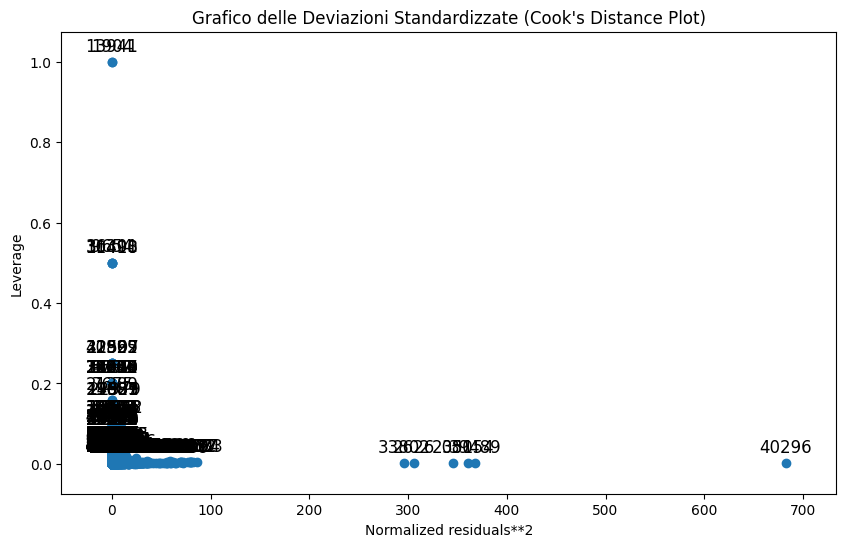

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_leverage_resid2

# Aggiungi una colonna di 1 per il termine costante
X_tr = sm.add_constant(X_train)

# Addestramento del modello di regressione
model = sm.OLS(y_train, X_tr).fit()

# Creazione del Grafico delle Deviazioni Standardizzate (Cook's Distance Plot)
fig, ax = plt.subplots(figsize=(10, 6))
plot_leverage_resid2(model, ax=ax)
plt.title("Grafico delle Deviazioni Standardizzate (Cook's Distance Plot)")
plt.show()


implement some regularization technique

In [26]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
# Creazione dei modelli
ridge_reg_cv = Ridge(alpha=1.0)  # Modifica il valore di alpha
lasso_reg_cv = Lasso(alpha=1.0)  # Modifica il valore di alpha

# Valutazione dei modelli con cross-validation
num_folds = 5
scoring = 'neg_mean_squared_error'  # Utilizza il negativo del MSE per valutare

ridge_scores = cross_val_score(ridge_reg_cv, X, y, scoring=scoring, cv=num_folds)
lasso_scores = cross_val_score(lasso_reg_cv, X, y, scoring=scoring, cv=num_folds)

# Converto i punteggi negativi del MSE in MSE positivi + sqrt
ridge_rmse_scores = np.sqrt(-ridge_scores)
lasso_rmse_scores = np.sqrt(-lasso_scores)

# Calcolo della media dei RMSE per ciascun modello
ridge_mean_rmse = np.mean(ridge_rmse_scores)
lasso_mean_rmse = np.mean(lasso_rmse_scores)

# Stampa dei risultati
print(f"Media RMSE per Ridge Regression: {ridge_mean_rmse}")
print(f"Media RMSE per Lasso Regression: {lasso_mean_rmse}")


Media MSE per Ridge Regression: 125.01591349764199
Media MSE per Lasso Regression: 98.74205538757957


**Lasso Regression (L1 Regolarizzazione):**

La Lasso Regression aggiunge un termine di penalizzazione L1 al termine dell'errore nella funzione obiettivo del modello. Questo termine di penalizzazione è proporzionale alla somma assoluta dei coefficienti del modello, portando alcuni coefficienti a diventare esattamente zero. La Lasso Regression è utile per la selezione delle caratteristiche, eliminando variabili meno rilevanti.

In [23]:
from sklearn.linear_model import Lasso
lasso_reg_i = Lasso(alpha=1.0)  # Puoi modificare il valore di alpha
lasso_reg_i.fit(X_train, y_train)
y_pred_lasso = lasso_reg_i.predict(X_test)

#model evaluation
#R^2:
score_lasso_reg = r2_score(y_test, y_pred_lasso)
print(score_lasso_reg)

#RMSE:
lasso_reg_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
print(lasso_reg_rmse)

0.5502831409103497
81.08826714217848


previous results seem to be less promising than the one provided by a simple linear regression. L1 penalty allows implicitly to identify relevant features. In particular the model reduces to zero variables coefficient, thus removing these variables, considered less relevant, from the model itself. However this kind of selection does not always improve the model performance, especially if the removed variables are weakly correlated to the target variable.....

elezione delle Caratteristiche: La regressione Lasso (L1) ha una tendenza a eseguire automaticamente la selezione delle caratteristiche, riducendo i coefficienti di alcune variabili a zero. Ciò significa che Lasso potrebbe eliminare alcune variabili ritenute meno rilevanti. Tuttavia, questa selezione delle caratteristiche potrebbe non sempre portare a miglioramenti significativi nelle prestazioni del modello, specialmente se le variabili eliminate hanno una bassa correlazione con il target.
Bias-Varianza Trade-off: La regressione Lasso tende a ridurre la complessità del modello attraverso la penalizzazione L1. Questo può aiutare a ridurre l'overfitting e migliorare le prestazioni quando ci sono molte variabili. Tuttavia, in alcuni casi, potrebbe anche introdurre un certo grado di bias, riducendo la capacità del modello di adattarsi perfettamente ai dati di addestramento.

**Ridge Regression (L2 Regolarizzazione):**

La Ridge Regression aggiunge un termine di penalizzazione L2 al termine dell'errore nella funzione obiettivo del modello. Questo termine di penalizzazione è proporzionale al quadrato dei coefficienti del modello, riducendo così la magnitudine dei coefficienti. La Ridge Regression è utile quando ci sono molte variabili indipendenti e potrebbe aiutare a prevenire l'overfitting.

In [24]:
from sklearn.linear_model import Ridge
ridge_reg_i = Ridge(alpha=1.0)  
ridge_reg_i.fit(X_train, y_train)
y_pred_ridge = ridge_reg_i.predict(X_test)

#model evaluation
#R^2:
score_ridge_reg = r2_score(y_test, y_pred_ridge)
print(score_ridge_reg)

#RMSE:
ridge_reg_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
print(ridge_reg_rmse)

0.6462969195523242
71.91307446183768


from previous result we can notice no particular difference from a simple linear regression.

In [32]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
#tuning and try to improve
# Creazione dei modelli
ridge_reg = Ridge()
lasso_reg = Lasso()

# Definizione dei parametri alpha da testare
alpha_values = np.logspace(-4, 4, 9)  # Esempio di valori di alpha

# Definizione dei parametri per la griglia di ricerca
param_grid = {'alpha': alpha_values}

# Creazione dell'oggetto GridSearchCV per la Ridge Regression
ridge_grid = GridSearchCV(ridge_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Creazione dell'oggetto GridSearchCV per la Lasso Regression
lasso_grid = GridSearchCV(lasso_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)

# Stampa dei risultati ottimali
print("Miglior valore di alpha per Ridge Regression:", ridge_grid.best_params_)
print("Miglior valore di alpha per Lasso Regression:", lasso_grid.best_params_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.276e+07, tolerance: 5.069e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.512e+07, tolerance: 5.135e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Miglior valore di alpha per Ridge Regression: {'alpha': 0.1}
Miglior valore di alpha per Lasso Regression: {'alpha': 0.0001}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.166e+08, tolerance: 6.354e+04
  model = cd_fast.enet_coordinate_descent(


In [33]:
ridge_best = ridge_grid.best_estimator_
y_pred_ridge_best = ridge_best.predict(X_test)
lasso_best = lasso_grid.best_estimator_
y_pred_lasso_best = lasso_best.predict(X_test)

#R^2:
score_ridge_reg_best = r2_score(y_test, y_pred_ridge_best)
score_lasso_reg_lasso = r2_score(y_test, y_pred_lasso_best)
print(f'after tuning the parameter alpha, the R^2 value of ridge model is: ',score_ridge_reg_best)
print(f'after tuning the parameter alpha, the R^2 value of lasso model is: ',score_lasso_reg_lasso)

0.6462352246297653
0.6462270504912468


**Polynomial Regression**

In [14]:
#starting from a basic version

# Fitting multivariate Polynomial Regression to the dataset
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2) #starting degree, only one we can run
X_poly_train = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)
 
poly.fit(X_poly_train, y_train) # let's fit the model
lin2 = LinearRegression()
lin2.fit(X_poly_train, y_train)

#model prediction on test
y_pred_poly = lin2.predict(X_poly_test)
#model coefficients
poly_reg_coef = lin2.coef_
print(lin2.coef_)

KeyboardInterrupt: 

In [11]:
#model evaluation
#R^2
print(f'R^2 on train set is : ', lin2.score(X_poly_train,y_train))
print(f'R^2 on test set is : ',lin2.score(X_poly_test,y_test)) #??
score_poly_reg = r2_score(y_test, y_pred_poly)

#RMSE
poly_reg_rmse = mean_squared_error(y_test, y_pred_poly, squared=False)
print(poly_reg_rmse)
#mean absolute error MAE
from sklearn.metrics import mean_absolute_error
poly_reg_mae = mean_absolute_error(y_test, y_pred_poly)

R^2 on train set is :  0.8115163306755211
R^2 on test set is :  -1.8889775807287645e+17
52553523256.23416


trovare modo per fare plot del grafico o comunque dei risultati

In [12]:
y_pred_poly

array([377.98199463,  93.60641479, 210.36639404, ..., 341.69418335,
       341.66491699, 134.32824707])

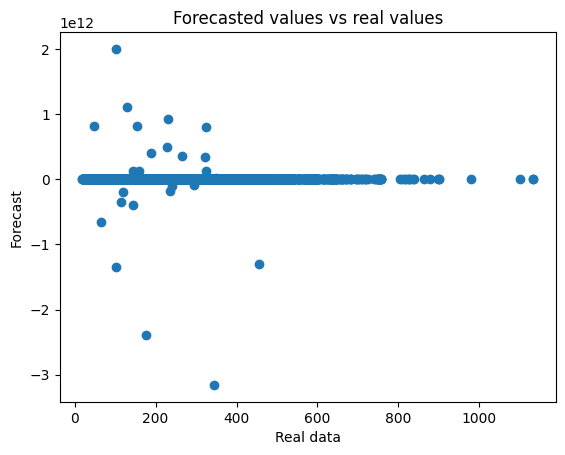

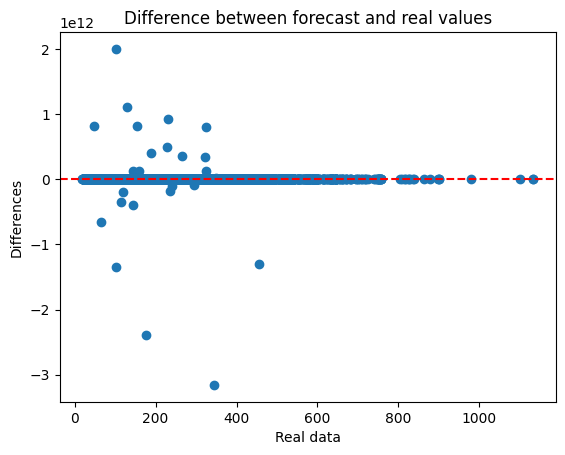

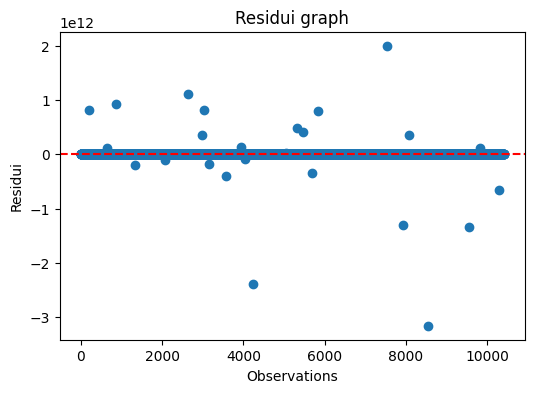

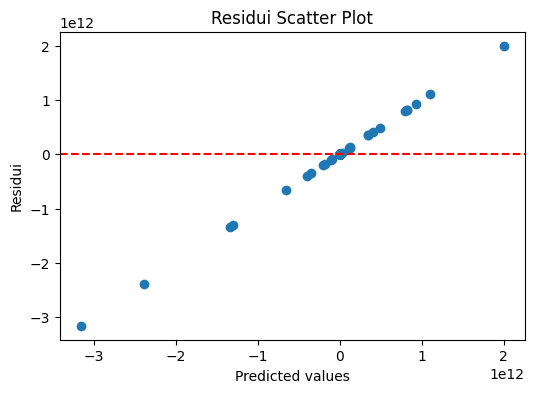

In [13]:
import matplotlib.pyplot as plt
#vedere perchè non vengono bene

# Grafico di previsione rispetto ai dati reali
plt.scatter(y_test, y_pred_poly)
plt.xlabel("Real data")
plt.ylabel("Forecast")
plt.title("Forecasted values vs real values")
plt.show()

# Grafico delle differenze tra previsioni e dati reali
differences = y_pred_poly - y_test
plt.scatter(y_test, differences)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Real data")
plt.ylabel("Differences")
plt.title("Difference between forecast and real values")
plt.show()

# Grafico dei residui
residuals = differences
plt.figure(figsize=(6, 4))
plt.scatter(np.arange(len(residuals)), residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Observations")
plt.ylabel("Residui")
plt.title("Residui graph")
plt.show()

# residui scatterplot

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_poly, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted values")
plt.ylabel("Residui")
plt.title("Residui Scatter Plot")
plt.show()

# Grafico della superficie di regressione polinomiale
#from mpl_toolkits.mplot3d import Axes3D

#x1, x2 = np.meshgrid(np.linspace(min(x[:, 0]), max(x[:, 0]), 100),
                     #np.linspace(min(x[:, 1]), max(x[:, 1]), 100))
#y_surface = 2 + 3 * x1 + 4 * x2 + 0.5 * x1 ** 2 + 0.8 * x2 ** 2

#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot_surface(x1, x2, y_surface, cmap='viridis')
#ax.scatter(x[:, 0], x[:, 1], y_real, c='r', marker='o')
#ax.set_xlabel('Feature 1')
#ax.set_ylabel('Feature 2')
#ax.set_zlabel('Valori reali')
#ax.set_title('Superficie di Regressione Polinomiale')
#plt.show()


Solving Overfitting Problem

Solving the overfitting problem starts with hyperparameter tuning. We should try different hyperparameters to find the optimum values where the model performs well on both training and testing data. This was a simple model. We have only one hyperparameter here which is the degree in the PolynomialFeatures method. 

__Grid Search for Hyperparameter Tuning__

Sklearn library provides us with functionality to define a grid of parameters and to pick the optimum one. Let us see how that can be used to decide on a proper degree for our prediction.

In [ ]:
#parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
param_grid = [
    {'poly__degree': [2, 3, 4, 5, 6]}
  ]
pipeline = Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge())])
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True) #rivedi lo score
grid_search.fit(X_train, y_train)

In [29]:
# check our accuracy for each degree, the lower the error the better!
number_degrees = [1,2,3,4,5,6]
plt_mean_squared_error = []
for degree in number_degrees:

   poly_model = PolynomialFeatures(degree=degree)
  
   poly_x_train = poly_model.fit_transform(X_train)
   poly_x_test = poly_model.transform(X_test)
   poly_model.fit(poly_x_train, y_train)
  
   regression_model = LinearRegression()
   regression_model.fit(poly_x_train, y_train)
   y_pred = regression_model.predict(poly_x_test)
  
   plt_mean_squared_error.append(mean_squared_error(y_test, y_pred, squared=False))
  
plt.scatter(number_degrees,plt_mean_squared_error, color="green")
plt.plot(number_degrees,plt_mean_squared_error, color="red") 

: 

: 

In [44]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

# Creazione del modello di regressione polinomiale con Ridge
poly_model_ridge = make_pipeline(PolynomialFeatures(), Ridge())

# Creazione del modello di regressione polinomiale con Lasso
poly_model_lasso = make_pipeline(PolynomialFeatures(), Lasso())

# Parametri da testare
param_grid_lasso = {
    'polynomialfeatures__degree': [1, 2],  # Gradi del polinomio
    'lasso__alpha': [0.01, 0.1, 1, 10]      # Parametri di regolarizzazione per Lasso
}    
param_grid_ridge = {
    'polynomialfeatures__degree': [1, 2],  # Gradi del polinomio
    'ridge__alpha': [0.01, 0.1, 1, 10]       # Parametri di regolarizzazione per Ridge
}

# Ricerca a griglia con cross-validation per Ridge
grid_search_ridge = GridSearchCV(poly_model_ridge, param_grid_ridge, cv=5)
grid_search_ridge.fit(X, y)

print("Miglior parametro per Ridge:", grid_search_ridge.best_params_)
print("Miglior punteggio di cross-validation per Ridge:", grid_search_ridge.best_score_)

# Ricerca a griglia con cross-validation per Lasso
grid_search_lasso = GridSearchCV(poly_model_lasso, param_grid_lasso, cv=5)
grid_search_lasso.fit(X, y)

print("Miglior parametro per Lasso:", grid_search_lasso.best_params_)
print("Miglior punteggio di cross-validation per Lasso:", grid_search_lasso.best_score_)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.35784e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.74462e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.54748e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.00274e-20): result may not be acc

Miglior parametro per Ridge: {'polynomialfeatures__degree': 1, 'ridge__alpha': 10}
Miglior punteggio di cross-validation per Ridge: 0.1462312512707186


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e+08, tolerance: 6.926e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.116e+08, tolerance: 6.566e+04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

**SVM**

Support Vector Machines (SVM) possono essere utilizzati anche per problemi di regressione, non solo per la classificazione. Nella regressione SVM, l'obiettivo è quello di trovare una funzione che si avvicini il più possibile ai dati di addestramento, mantenendo un certo margine. Questo può essere utile per affrontare problemi di regressione non lineare. La SVM per la regressione utilizza l'obiettivo di minimizzare l'errore rispetto a una soglia specificata (epsilon) e cercare di massimizzare il margine. I parametri C e kernel influenzano la complessità del modello e la flessibilità nell'adattamento ai dati.

In [18]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

#define model and parameters to tune
svr_param_grid = {
    'kernel':['poly', 'rbf', 'linear'], # Tipo di kernel 
    'C':[10, 1.0, 0.1, 0.01, 0.001], # Parametro di regolarizzazione (più grande C, meno regolarizzazione)
    'epsilon': [0.01, 0.1, 0.2] # Tolleranza per la soglia dell'errore
}

# Crea il modello SVR
#svm_regressor = SVR()
svr_model = SVR()

grid_svr_grid = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, n_jobs=-1, cv=5)
grid_svr_grid.fit(X_train, y_train)

#summarize results
print("Best parameters:", grid_svr_grid.best_params_)
print("Best score:", grid_svr_grid.best_score_)

#model evaluation with X_test dataset
svm_metric = grid_svr_grid.score(X_test, y_test)
print("R^2 on test set:", svm_metric)

KeyboardInterrupt: 

Tuttavia, tieni presente che le SVM per la regressione potrebbero non essere sempre la scelta migliore, soprattutto se il tuo dataset è molto grande. Altre tecniche come le regressioni lineari o alberi decisionali potrebbero essere più adatte in alcune situazioni.

**Random Forest Regression**

In [ ]:
#start tuning parameters for random forest
from sklearn.model_selection import RandomizedSearchCV
rfc_i = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rcv = RandomizedSearchCV(rfc_i, random_grid, n_iter = 100,verbose=1, n_jobs=-1)
rcv.fit(X_train,y_train)

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#verify if there is an improvement with respect to the base model
base_model = RandomForestRegressor(n_estimators=10,randomstate=42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rcv.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)


Since we have better results after tuning paramteres, according to the parameters identified by random search grid we can...implement a gridsearch more narrow down etc

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

In [1]:

# Model training versione base
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)

# Model R2 on Training & Test
print('Model Performance on Training Set:', round(rf_reg.score(X_train, y_train)*100,2))
print('Model Performance on Test Set:', round(rf_reg.score(X_test, y_test)*100,2))

# Plot performance graph
y_pred = rf_reg.predict(X_test)
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

# Model Error Values
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# RMSE = sqrt((PV-OV)^2/n)
print('Normalized RMSE ', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred))/(max(y_test)-min(y_test)),2))
# RMSE/(max(DV)-min(DV))
print('Max Value: ', max(y), '\nMin Value: ', min(y))


KeyboardInterrupt: 